In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = 'data/2024-08-19/'
funds = ['fssa-asia-focus', 'hl-select', 'lg-european', 'lg-international', 'manglg-japan', 'rathbone-global' ]

portfolio = {
    'rathbone-global':  389.39,
    'fssa-asia-focus':  333.208,
    'lg-european':      138.476,
    'lg-international': 307.269,
    'manglg-japan':     293.275,
    'hl-select':        296.755,
}

In [3]:
# Read funds CSVs
fund_dfs = {}

for filename in funds:
    df = pd.read_csv(filepath_or_buffer=f'{data_dir}/{filename}.csv', parse_dates=True)
    df['Identifier'] = filename
    fund_dfs[filename] = df.bfill()

# Align Adjusted Close time series by date in pivot table with funds as columns
pivoted = pd.concat([fund_dfs[k] for k in fund_dfs.keys()]).pivot(index='Date', columns='Identifier', values='Adj Close').bfill()
display(pivoted.head())

Identifier,fssa-asia-focus,hl-select,lg-european,lg-international,manglg-japan,rathbone-global
Date,,,,,,
2023-08-21,208.034393,144.446289,336.710510,163.272934,226.768631,349.966614
2023-08-22,208.354324,144.586288,337.610291,163.972809,229.468246,350.676575
2023-08-23,211.693756,145.816269,338.410065,165.072632,233.967621,353.116486
2023-08-24,213.173508,147.226227,339.609772,166.872330,233.567688,355.676392
2023-08-25,212.003693,146.686234,338.410065,165.472580,232.567825,353.486481


<Figure size 1200x1200 with 0 Axes>

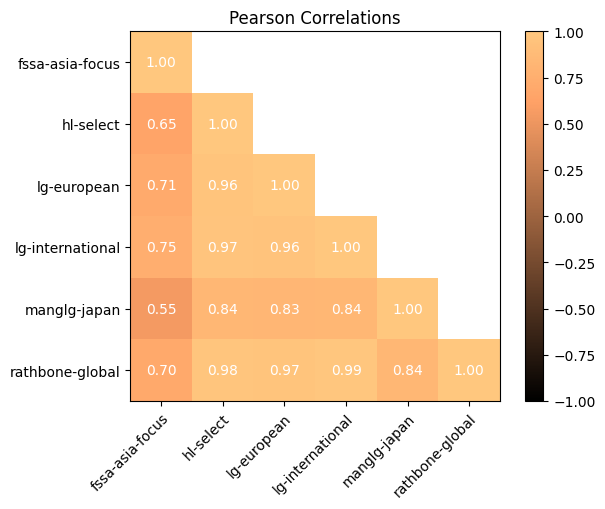

<Figure size 1200x1200 with 0 Axes>

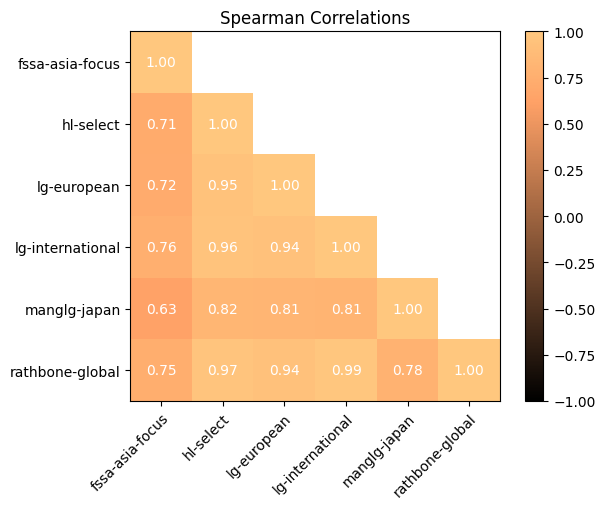

<Figure size 1200x1200 with 0 Axes>

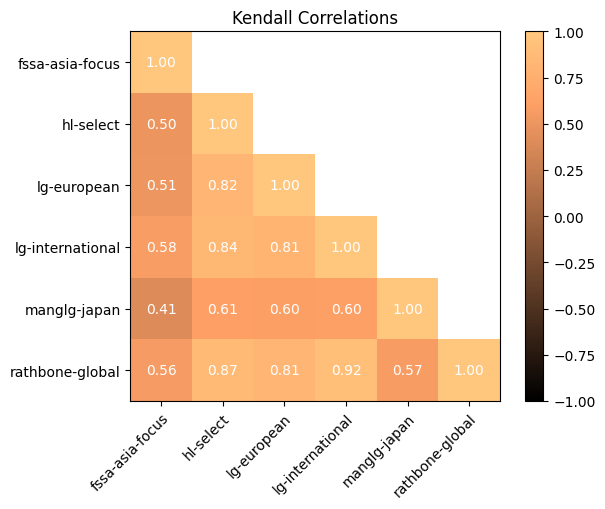

In [4]:
# Calculate and plot pearson, spearman, and kendall correlation heatmaps
for m in ['pearson', 'spearman', 'kendall']:
    c = pivoted.corr(method=m)
    plt.figure(figsize = (12,12))
    fig, ax = plt.subplots()
    data = c.to_numpy()
    mask = np.tri(data.shape[0], data.shape[1], k=-1).T
    data = np.ma.array(data, mask=mask)
    labels = c.columns
    a = plt.imshow(data, cmap = 'copper', interpolation = 'nearest', vmin=-1, vmax=1)
    fig.colorbar(a)

    ax.set_xticks(range(len(c)), labels=c.columns, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(range(len(c)), labels=c.columns)
    ax.set_title(f'{m.capitalize()} Correlations')

    for i in range(len(labels)):
        for j in range(i+1):
            ax.text(j, i, f'{data[i, j]:.2f}', ha='center', va='center', color='w')

    plt.show()


<Figure size 1600x1600 with 0 Axes>

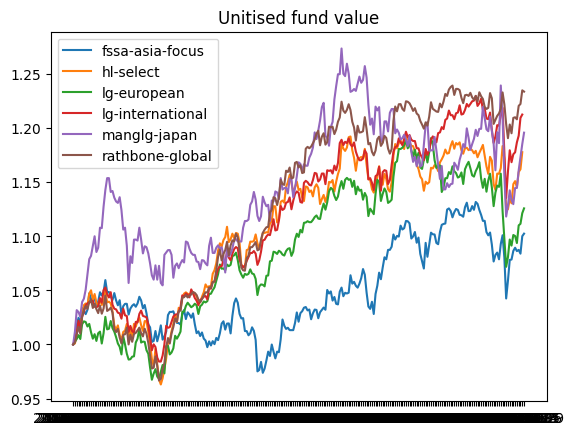

In [5]:
# Display relative price evolution of each fund
plt.figure(figsize=(16, 16))
fig, ax = plt.subplots()
ax.set_title('Unitised fund value')
for f in pivoted.columns:
    c = pivoted[f]
    ax.plot(pivoted.index, c / c.iloc[0], label=f)

plt.legend()
plt.show()

Date
2023-08-21    4117.579883
2023-08-22    4133.139666
2023-08-23    4175.100172
2023-08-24    4200.201280
2023-08-25    4177.278960
dtype: float64

<Figure size 1600x1600 with 0 Axes>

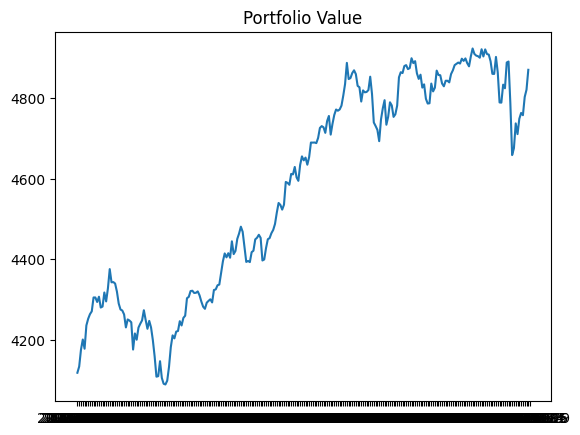

In [6]:
# Display overall portfolio value
units = [portfolio.get(x, 0) for x in pivoted.columns]
pf = pivoted @ units / 100
display(pf.head())

plt.figure(figsize=(16, 16))
fig, ax = plt.subplots()
ax.set_title('Portfolio Value')
ax.plot(pf.index, pf, label='Portfolio Value')

plt.show()